In [1]:
#importing packages

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import SimpleRNN,Dropout

**Dataset Cleaning**

In [2]:
data_steel = pd.read_csv("/content/Stainless-Steel-Prices-Forecasty-Assignment.csv")

In [3]:
data_steel.head()

,Date,StainlessSteelPrice,Steel_Inventory_M_USD,Steel_Orders_M_USD,IronOre_Global_USD,CoalAustralia_Global_USD,Energy_Index,Nickel_Global_USD,Zinc_Global_USD,Freight_Transport_Index,WTI_Crude_Global_USD,Baltic_Dry_Index,BCI_China,BCI_Europe,BCI_US,CLI_China,CLI_Europe,CLI_US,PMI_US_Manufacturing,Copper_Global_USD
0,7/1/2013,0.827352,20575,10568,127.191304,82.222360,227.022942,13750.31522,1837.619565,-0.4,104.545217,1062,98.80018,99.64265,100.1044,101.1423,99.43615,100.6230,50.9,6906.64
1,8/1/2013,0.760221,20609,10821,137.055000,82.221429,232.234194,14308.26190,1896.392857,0.5,106.546364,1132,99.04874,99.91766,100.3962,101.1938,99.64082,100.6545,55.4,7186.25
2,9/1/2013,0.784715,20761,10774,134.185714,83.295918,234.335594,13801.39286,1846.880952,0.1,106.313809,2003,99.27196,100.18490,100.5363,101.2066,99.84383,100.6646,55.7,7159.27
3,10/1/2013,0.769293,20735,11291,132.572727,85.443634,229.393932,14117.65217,1884.836957,-0.1,100.500435,1504,99.40488,100.36330,100.5771,101.1835,100.02300,100.6666,56.2,7203.02
4,11/1/2013,0.750242,20854,11559,136.323810,88.363265,225.437049,13684.01190,1866.416667,2.1,93.812381,1821,99.36221,100.49830,100.5459,101.1283,100.17150,100.6744,56.4,7070.65


In [4]:
data_steel['Date'] = pd.to_datetime(data_steel['Date'])

In [5]:
data_steel.set_index("Date", inplace= True)

In [6]:
data_steel.index.freq = "MS"

In [7]:
dataset = data_steel.copy()

In [8]:
dataset.drop(dataset.iloc[:, 1:], inplace = True, axis = 1)

In [9]:
dataset.head()

,StainlessSteelPrice
Date,
2013-07-01,0.827352
2013-08-01,0.760221
2013-09-01,0.784715
2013-10-01,0.769293
2013-11-01,0.750242


In [10]:
##Normalizing the whole dataset to see the plot

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['StainlessSteelPrice']=scaler.fit_transform(df['StainlessSteelPrice'].values.reshape(-1,1))
    return df

df_norm = normalize_data(dataset)
df_norm.shape

(84, 1)

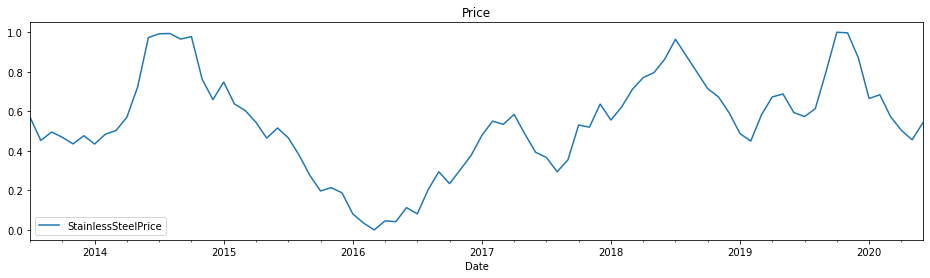

In [11]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('Price')

plt.show()

In [12]:
##Dataset
## As we have only 84 months of data, and as we devided the data into train and test the train data consist of 64 month and test data rest
## so according to that we have to build our model

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[64:]             
    y_test = y_train[64:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:64]           
    y_train = y_train[:64]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_train = np.reshape(X_train, (64, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [13]:
## 10 seq length

seq_len = 10 

X_train, y_train, X_test, y_test = load_data(dataset, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (64, 10, 1)
y_train.shape =  (64,)
X_test.shape =  (10, 10, 1)
y_test.shape =  (10,)


**LSTM MODEL**

In [20]:
#Model parameters and model building

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.20))

lstm_model.add(LSTM(40,activation="relu",return_sequences=True))
lstm_model.add(Dropout(0.20))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.20))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 40)            6720      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 40)            12960     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
#optimizer = adam and loss is MAPE

lstm_model.compile(optimizer="adam",loss="MAPE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 54603.5508
Epoch 2/10
1/1 [==============================] - 0s 27ms/step - loss: 235928.9219
Epoch 3/10
1/1 [==============================] - 0s 32ms/step - loss: 178975.6094
Epoch 4/10
1/1 [==============================] - 0s 31ms/step - loss: 29332.2773
Epoch 5/10
1/1 [==============================] - 0s 29ms/step - loss: 39952.4297
Epoch 6/10
1/1 [==============================] - 0s 28ms/step - loss: 90630.9062
Epoch 7/10
1/1 [==============================] - 0s 31ms/step - loss: 194081.5156
Epoch 8/10
1/1 [==============================] - 0s 33ms/step - loss: 13135.9287
Epoch 9/10
1/1 [==============================] - 0s 30ms/step - loss: 24195.5215
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 30552.1348


In [23]:
def directional(y, y_hat):
    n = len(y)
    yd = np.array(y)
    y_hatd = np.array(y_hat)
    
    i = 1
    nsum =0
    for i in range(1, len(yd)):

        if(((yd[i]-yd[i-1]) * (y_hatd[i]-y_hatd[i-1])) > 0):
            value = 1
            nsum = nsum + value
    result = np.multiply(np.divide(100, n-1), nsum)
    return result

In [24]:
#prediction

lstm_predictions = lstm_model.predict(X_test)
dire = directional(y_test, lstm_predictions)
lstm_score = r2_score(y_test, lstm_predictions)
print("Directional Symmetry Score of LSTM model = ",dire)
print("R^2 Score of LSTM model = ",lstm_score)

Directional Symmetry Score of LSTM model =  88.88888888888889
R^2 Score of LSTM model =  -14.109174389767317


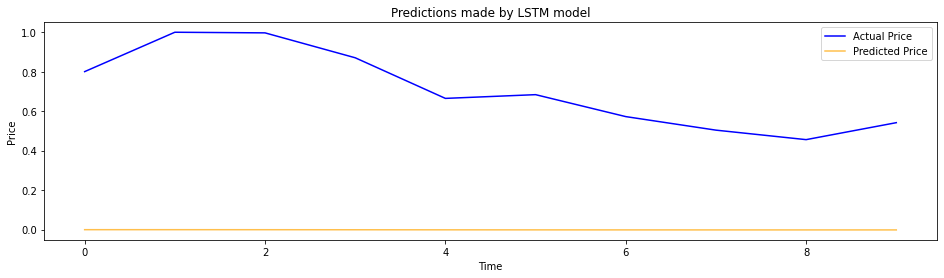

In [25]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual Price')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

**RNN MODEL**

In [40]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="sigmoid",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 10, 40)            1680      
_________________________________________________________________
dropout_27 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 10, 40)            3240      
_________________________________________________________________
dropout_28 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [43]:
rnn_model.compile(optimizer="adam",loss="MAPE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=100)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3737745.2500
Epoch 2/10
1/1 [==============================] - 0s 19ms/step - loss: 2286528.5000
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 5373889.5000
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 4813605.0000
Epoch 5/10
1/1 [==============================] - 0s 19ms/step - loss: 1115410.5000
Epoch 6/10
1/1 [==============================] - 0s 18ms/step - loss: 1659315.1250
Epoch 7/10
1/1 [==============================] - 0s 19ms/step - loss: 811999.2500
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 7993526.0000
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 5181652.5000
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 9401349.0000


In [45]:
rnn_predictions = rnn_model.predict(X_test)
dire = directional(y_test, rnn_predictions)
rnn_score = r2_score(y_test,rnn_predictions)
print("Directional Symmetry Score of RNN model = ", dire)
print("R2 Score of RNN model = ",rnn_score)

Directional Symmetry Score of RNN model =  55.55555555555556
R2 Score of RNN model =  -8.959378365713002


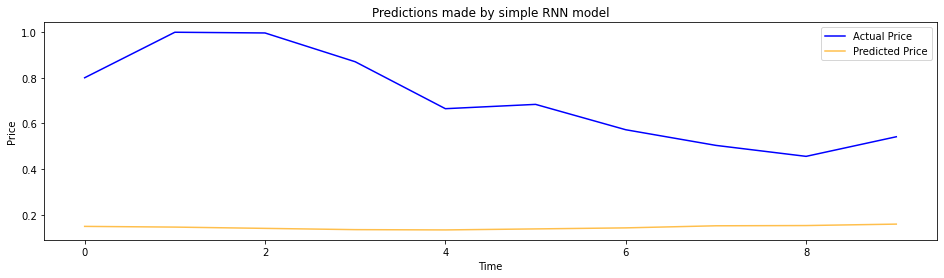

In [46]:
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

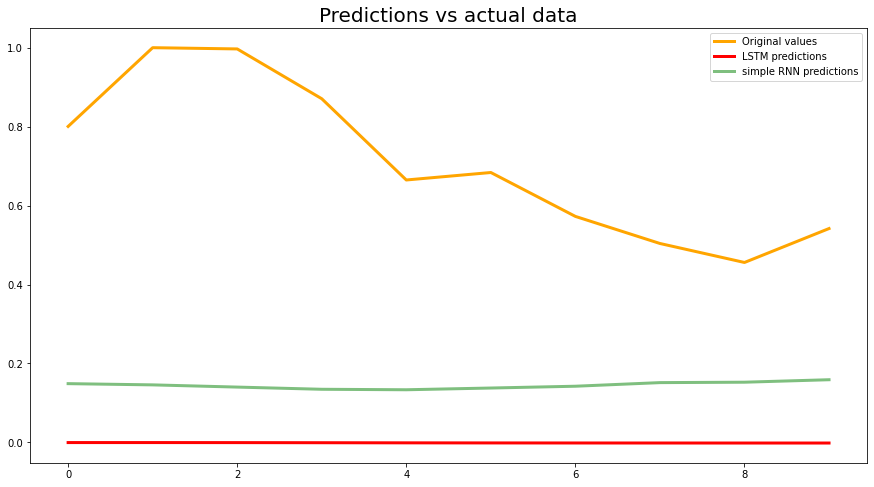

In [47]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="simple RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

**Hybrid Model**

In [54]:
hybrid_model = Sequential()

hybrid_model.add(SimpleRNN(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
hybrid_model.add(Dropout(0.15))

hybrid_model.add(LSTM(40,activation="relu",return_sequences=True))
hybrid_model.add(Dropout(0.15))

hybrid_model.add(SimpleRNN(40,activation="sigmoid",return_sequences=False))
hybrid_model.add(Dropout(0.15))

hybrid_model.add(Dense(1))

hybrid_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_22 (SimpleRNN)    (None, 10, 40)            1680      
_________________________________________________________________
dropout_36 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 10, 40)            12960     
_________________________________________________________________
dropout_37 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_38 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [55]:
hybrid_model.compile(optimizer="adam",loss="MAPE")
hybrid_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 8004178.0000
Epoch 2/10
1/1 [==============================] - 0s 24ms/step - loss: 3168169.0000
Epoch 3/10
1/1 [==============================] - 0s 23ms/step - loss: 68944.0703
Epoch 4/10
1/1 [==============================] - 0s 24ms/step - loss: 11298334.0000
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 1846449.0000
Epoch 6/10
1/1 [==============================] - 0s 23ms/step - loss: 10714457.0000
Epoch 7/10
1/1 [==============================] - 0s 21ms/step - loss: 6114258.0000
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 6401671.5000
Epoch 9/10
1/1 [==============================] - 0s 28ms/step - loss: 6715959.0000
Epoch 10/10
1/1 [==============================] - 0s 26ms/step - loss: 1142023.5000


In [56]:
hybrid_predictions = hybrid_model.predict(X_test)
dire = directional(y_test, hybrid_predictions)
hybrid_score = r2_score(y_test,hybrid_predictions)
print("Directional Symmetry Score of Hybrid model = ", dire)
print("R2 Score of RNN-LSTM model = ",hybrid_score)

Directional Symmetry Score of Hybrid model =  66.66666666666666
R2 Score of RNN-LSTM model =  -12.649624113586075


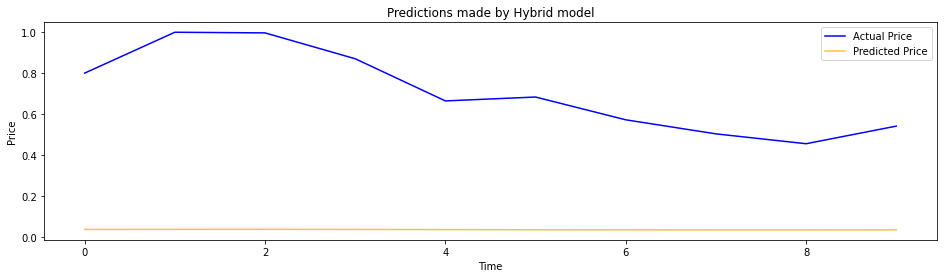

In [57]:
plot_predictions(y_test, hybrid_predictions, "Predictions made by Hybrid model")

I tried the LSTM, RNN and Hybrid method for the prediction. Results are not good enough and the deep learning algorithms failed.

I changed the hyperparameters and activation functions to (relu, tanh and sigmoid) check the result. sigmoid on the last layer gives a better DS value and MAPE value. However, tanh gives the worst result. 

